In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Goal: Extract information about the results of each model.

As different state-of-the-art source separation systems use different methods of recording metrics, we define our own way of calculating it on the MUSDB18 dataset:

1. For each song in the MUSDB18 dataset, create overlapping 8 second chunks, where the first chunk of each song is at 0 seconds, and each subsequent chunk starts 4 seconds after the previous one.

2. Remove chunks that do not have adaquate sound for all sources. For each song, this is done by finding the chunk with the maximum power in each source, which we call the reference chunk, and removing all chunks with power less than 8 db than the reference chunk.

3. Separate the mix in each chunk using the desired model. Record metrics. 

4. Summary statistics are mean, median, and standard deviation. To calculate the summary statistics of a metric for one source, we calculate the statistic over the recorded metric over all chunks. To calculate the summary statistics of a metric over all sources, we first find the mean metric for all sources in each chunk, then we calculate the summary statistics over these means. 

This method of calculating metrics was concieved before calculating summary statistics of any model, and no intentional bias exists toward any model, which may not be the case for evaluation methods in other papers. 

In [6]:
import os
from tqdm import tqdm
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
sns.set_theme()
from nussl.core.play_utils import multitrack
from dataset import MUSDB18Segmented, root, segmentation_file
from load_models import wav_u_net, demucs, tasnet, open_unmix
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

musdb = MUSDB18Segmented(folder=root, load_seg=True)
models = {
    'OpenUnmix': open_unmix().cuda(),
    "WaveUNet": wav_u_net(352_800).cuda(),
    "Demucs": demucs().cuda(),
    "ConvTasNet": tasnet().cuda()
}
 
# Define helper functions
# Load a CSV with pd.read_csv(path)
def split_into_sources(df):
    """
    Returns a dictionary of dataframes
    """
    groups = df.groupby(by="source")
    return {name: g_df for name, g_df in groups}

def calculate_sum_stats(df):
    """
    Returns a pandas.DataFrame, where each row is a metric,
    and the columns are 'mean', 'median', 'std dev' respectively.
    """
    metrics = []
    data = []
    for col in df:
        if col in ["source", "file", "Unnamed: 0"]:
            continue
        metrics.append(col)
        data.append(
            {
                'mean': df[col].mean(),
                'median': df[col].median(),
                'std dev': df[col].std()
            }
        )
    return pd.DataFrame(
        data=data, index=metrics
    )

def aggreggate_sources(df_dict):
    """
    Takes a dictionary of dataframes, and find the mean
    for each track's metrics across sources.

    Returns a new dataframe containing the mean of each file.
    """
    
    df_concat = pd.concat(df_dict.values())
    by_file = df_concat.groupby(by="file")
    df_all = by_file.mean()
    return df_all

def get_musdb_song(json_file):
    name, _ = os.path.splitext(json_file)
    item = musdb[int(name)]
    return item
    

Using valid convolutions with 363177 inputs and 353625 outputs


In [8]:
# Gathering data
raw_data = {}
# To add new models, only a single line here must be added
raw_data["OpenUnmix"] = pd.read_csv("results/OpenUnmix/MUSDB18Segmented_train/aggreggate.csv")
raw_data["Demucs"] = pd.read_csv("results/Demucs/MUSDB18Segmented_train/aggreggate.csv")
raw_data["ConvTasNet"] = pd.read_csv("results/ConvTasNet/MUSDB18Segmented_train/aggreggate.csv")
raw_data["Wave-U-Net"] = pd.read_csv("results/Wave-U-Net/MUSDB18Segmented_train/aggreggate.csv")
# raw_data["IRM"] = pd.read_csv("results/IRM/MUSDB18Segmented/aggreggate.csv")
def summary_stats_sources(df_dict):
    sum_dict = {}
    for name, df in df_dict.items():
        sum_dict[name] = calculate_sum_stats(df)
    return sum_dict
def generate_aggreggates(raw_data):
    raw_source_data = {}
    for name, df in raw_data.items():
        raw_source_data[name] = split_into_sources(df)

    summary_source_data = {}
    for name, dict_df in raw_source_data.items():
        summary_source_data[name] = summary_stats_sources(dict_df)

    raw_aggreggate_data = {}
    for name, dict_df in raw_source_data.items():
        raw_aggreggate_data[name] = aggreggate_sources(dict_df)

    summary_aggreggate_data = {}
    for name, df in raw_aggreggate_data.items():
        summary_aggreggate_data[name] = calculate_sum_stats(df)
    return raw_source_data, summary_source_data, raw_aggreggate_data, summary_aggreggate_data
raw_source_data, summary_source_data, raw_aggregate_data, summary_aggreggate_data = generate_aggreggates(raw_data)


## Part 1: Aggregation Methods, and their deviation from papers with code.
First considering all sources, then source by source.

In [4]:
for name, df in summary_aggreggate_data.items():
    display(name)
    display(df.loc[["SNR", "SI-SDR", "SI-SDRi"]])

NameError: name 'summary_aggreggate_data' is not defined

Observations: 
+  Demucs destroys ConvTasnet on the training set, as opposed to the testing set, where Conv-TasNet beats out Demucs

In [ ]:
## How does this hold across sources?
for name, df_dict in summary_source_data.items():
    display(name)
    to_concat = []
    for source, df in df_dict.items():
        values = df.loc[["SNR", "SI-SDR", "SI-SDRi"]]
        values.rename({"SNR": f"{source}: SNR",
                       "SI-SDR": f"{source}: SI-SDR",
                       "SI-SDRi": f"{source}: SI-SDRi"},
                      inplace=True)
        to_concat.append(values)
    df_concat = pd.concat(to_concat)
    display(df_concat)

### Observations
+ Demucs beats ConvTasNet in all sources in mean SNR and SI-SDR
+ Wave-U-Net is competitive to Demucs and CTN, unlike in the test set.

## SAR

In [6]:
for name, df in summary_aggreggate_data.items():
    display(name)
    display(df.loc[["SI-SAR"]])

'OpenUnmix'

,mean,median,std dev
SI-SAR,5.70636,6.358413,3.479595


'Demucs'

,mean,median,std dev
SI-SAR,7.89838,8.561286,3.751447


'ConvTasNet'

,mean,median,std dev
SI-SAR,6.525706,7.195589,3.75406


'Wave-U-Net'

,mean,median,std dev
SI-SAR,4.95324,6.38012,4.407864


# Part 2: Graphs, and the anomalies in them

'OpenUnmix'

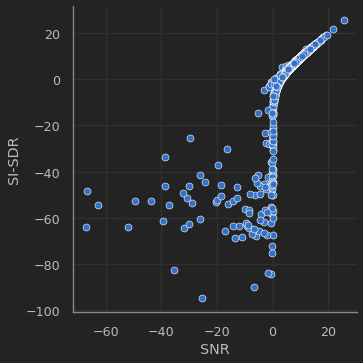

'Demucs'

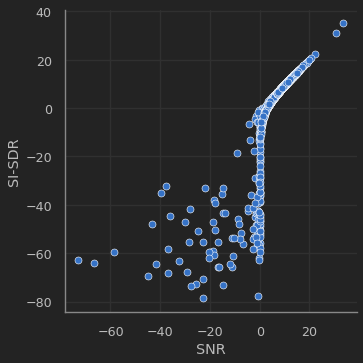

'ConvTasNet'

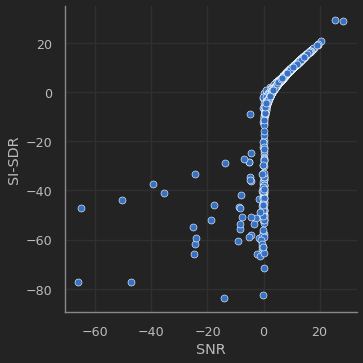

'Wave-U-Net'

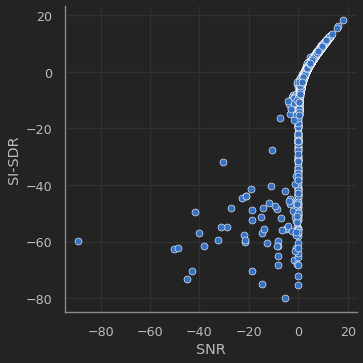

In [7]:
## We actually do have an SDR of a single window, its SNR from the BSSEvalScale
for model_name, dict_df in raw_source_data.items():
    display(model_name)
    sns.relplot(data=dict_df['vocals']
                # [dict_df["vocals"]["SI-SDR"] > 0]
                , x="SNR", y="SI-SDR")
    plt.grid()
    plt.show()

Interesting fact: There is not a single clip that acheived an SI-SDR that is far better than SDR. This implies that solely scaling errors are not errors that would occur under these systems. 

##### To no ones surprise, low SNR and SI-SDR have very contaminated sources, or are silent

# Part 3: Outlier removal

In [8]:
# We know that Happy Daze, Oh no!, and Pony, are far removed from the rest of the songs. What other songs cause trouble for the models?
# SI-SDR of less than 0 is the threshold for a "bad chunk".

# This results in `bad_chunk_df`, a pd.DataFrame containing the marginal proportion of chunks for each test stem and model that had a low SI-SDR.
# (Which is classified as an SI-SDR of less than 0)
sources = ["bass", "drums", "other", "vocals"]
bad_chunks = OrderedDict()
for model_name, _df in raw_data.items():
    if model_name == "IRM":
        continue
    df = _df.loc[_df["SI-SDR"] < 0]
    df["Song Number"] = df["file"].apply(
        lambda f: musdb._get_musdb_idx(int(os.path.splitext(f)[0]))[1]
    )
    groups = df.groupby(["Song Number", "source"])
    _bad_chunks = {s: {} for s in sources}
    for source in sources:
        for num in range(50):
            _bad_chunks[source][num] = (
                len(groups.get_group((num, source))) / len(musdb.segments[num])
                if (num, source) in groups.groups.keys()
                else 0
            )
    bad_chunks[model_name] = pd.DataFrame(_bad_chunks)
bad_chunks_df = pd.concat(
    [df.rename(columns={s: f"{model_name}_{s}" for s in sources})
     for model_name, df in bad_chunks.items()], axis=1
)
display(bad_chunks_df)


/home/ubuntu/anaconda3/envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/ubuntu/anaconda3/envs/meta/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,OpenUnmix_bass,OpenUnmix_drums,OpenUnmix_other,OpenUnmix_vocals,Demucs_bass,Demucs_drums,Demucs_other,Demucs_vocals,ConvTasNet_bass,ConvTasNet_drums,ConvTasNet_other,ConvTasNet_vocals,Wave-U-Net_bass,Wave-U-Net_drums,Wave-U-Net_other,Wave-U-Net_vocals
0,0.000000,1.000000,0.000000,0.068966,0.000000,0.137931,0.000000,0.068966,0.000000,1.000000,0.000000,0.068966,0.000000,0.103448,0.000000,0.413793
1,0.000000,0.122449,0.061224,0.000000,0.000000,0.020408,0.020408,0.000000,0.000000,0.142857,0.040816,0.000000,0.122449,0.857143,0.755102,0.571429
2,0.000000,0.083333,0.138889,0.083333,0.000000,0.027778,0.055556,0.000000,0.000000,0.055556,0.277778,0.166667,0.000000,0.166667,0.805556,0.222222
3,0.000000,0.000000,0.475000,0.100000,0.050000,0.000000,0.450000,0.100000,0.000000,0.000000,0.475000,0.100000,0.000000,0.000000,0.900000,0.125000
4,0.000000,0.023810,0.380952,0.190476,0.000000,0.047619,0.357143,0.214286,0.000000,0.023810,0.333333,0.190476,0.000000,0.023810,0.500000,0.142857
5,0.176471,0.000000,0.000000,0.000000,0.176471,0.000000,0.000000,0.000000,0.176471,0.000000,0.029412,0.000000,0.000000,0.029412,0.294118,0.000000
6,0.129032,0.000000,0.000000,0.000000,0.096774,0.000000,0.000000,0.000000,0.129032,0.000000,0.000000,0.000000,0.000000,0.000000,0.322581,0.032258
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064516,0.935484,0.000000
8,0.000000,0.045455,0.022727,0.090909,0.000000,0.022727,0.022727,0.090909,0.000000,0.022727,0.022727,0.113636,0.000000,0.022727,0.363636,0.136364
9,0.121212,0.000000,0.000000,0.060606,0.060606,0.000000,0.000000,0.060606,0.030303,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.060606


Remove the tracks by PR, as well as Pony.
PR has the files `[918.json, 939.json)` while Pony has the files `[1468.json, 1523.json)`.
If we remove these tracks, it appears that some of the datapoints on the scatterplots with lower SNR and SI-SDRs will disappear, but not all of them. 

In [13]:
# This will output the top ten problematic stems for each source and model, as well as their low SI-SDR rate.
# This will also find the stems that have at least a 70% low SI-SDR rate for all models, for each source.
top = 10
problem_songs = {}
for column, column_series in bad_chunks_df.iteritems():
# This clutters up the notebook, but you can see the problematic songs by uncommenting
# The following 5 lines
#     display(column)
#     top_df = column_series.sort_values(
#         axis=0, ascending=False
#     ).iloc[:top]
#     display(top_df)
    bad_songs = set(column_series[column_series > .7].index)
    source = column[column.rfind("_") + 1:]
    problem_songs[source] = bad_songs.intersection( # change this to union, to see songs that only fail at >1 songs
        problem_songs.get(source, bad_songs)
    )

songs = sorted(os.listdir("/exports/projects/computer-audition/data/musdb/raw/stems/train"))
print("PROBLEM SONGS")
for source, indices in problem_songs.items():
    print(source)
    for idx in indices:
        print(f"{idx}:\t{songs[idx]}")

PROBLEM SONGS
bass
49:	Leaf - Wicked.stem.mp4
drums
49:	Leaf - Wicked.stem.mp4
21:	Clara Berry And Wooldog - Waltz For My Victims.stem.mp4
other
49:	Leaf - Wicked.stem.mp4
vocals
49:	Leaf - Wicked.stem.mp4


Outliers for source bass
{'1622.json', '1616.json', '1635.json', '1617.json', '1648.json', '1646.json', '1629.json', '1647.json', '1619.json', '1649.json', '1641.json', '1650.json', '1636.json', '1642.json', '1618.json', '1644.json', '1623.json', '1628.json', '1615.json', '1638.json', '1651.json', '1625.json', '1639.json', '1614.json', '1630.json', '1626.json', '1640.json', '1633.json', '1643.json', '1634.json', '1645.json', '1627.json', '1624.json', '1621.json', '1631.json', '1620.json', '1637.json', '1632.json'}


'OpenUnmix'

,mean,median,std dev
SNR,7.282999,7.226429,4.135544
SI-SDR,5.915204,6.461837,6.030965
SI-SDRi,11.496354,11.341859,4.566154


'Demucs'

,mean,median,std dev
SNR,10.894382,10.879191,4.620501
SI-SDR,10.243418,10.739560,6.554598
SI-SDRi,15.845808,15.858722,4.785727


'ConvTasNet'

,mean,median,std dev
SNR,9.331014,9.266206,3.970516
SI-SDR,7.956986,8.852513,8.019512
SI-SDRi,13.559376,13.696811,5.231507


'Wave-U-Net'

,mean,median,std dev
SNR,9.635185,9.704454,5.246335
SI-SDR,8.101845,9.286231,8.883492
SI-SDRi,13.704235,14.972803,6.262762


'OpenUnmix'

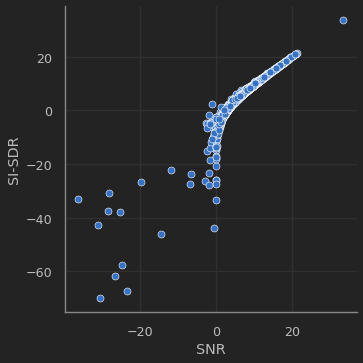

'Demucs'

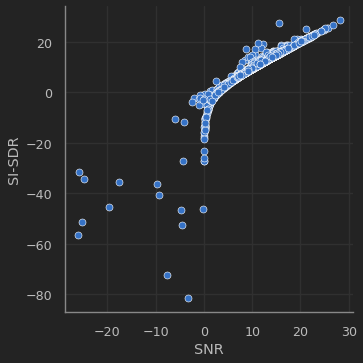

'ConvTasNet'

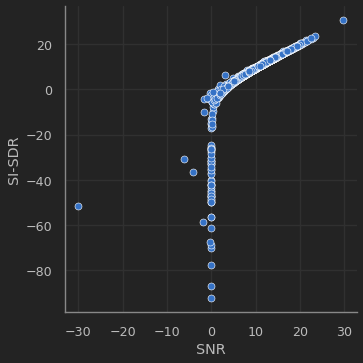

'Wave-U-Net'

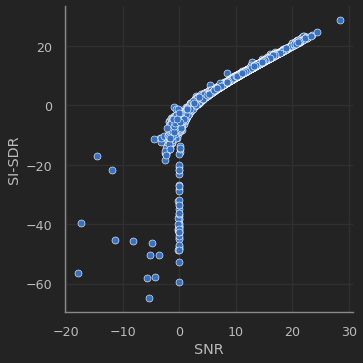

Outliers for source vocals
{'1622.json', '1616.json', '1635.json', '1617.json', '1648.json', '1646.json', '1629.json', '1647.json', '1619.json', '1649.json', '1641.json', '1650.json', '1636.json', '1642.json', '1618.json', '1644.json', '1623.json', '1628.json', '1615.json', '1638.json', '1651.json', '1625.json', '1639.json', '1614.json', '1630.json', '1626.json', '1640.json', '1633.json', '1643.json', '1634.json', '1645.json', '1627.json', '1624.json', '1621.json', '1631.json', '1620.json', '1637.json', '1632.json'}


'OpenUnmix'

,mean,median,std dev
SNR,7.494299,7.908689,5.293881
SI-SDR,5.250275,7.185907,11.236197
SI-SDRi,11.860235,12.436806,6.034914


'Demucs'

,mean,median,std dev
SNR,8.191329,8.491982,5.534589
SI-SDR,5.970284,7.851702,11.402277
SI-SDRi,12.624159,13.066620,6.044700


'ConvTasNet'

,mean,median,std dev
SNR,7.602050,7.671665,4.552045
SI-SDR,5.122475,6.910340,10.895817
SI-SDRi,11.776349,12.044464,5.689639


'Wave-U-Net'

,mean,median,std dev
SNR,4.995575,5.251270,4.462160
SI-SDR,1.222957,3.761178,11.592931
SI-SDRi,7.876832,8.757827,6.173336


'OpenUnmix'

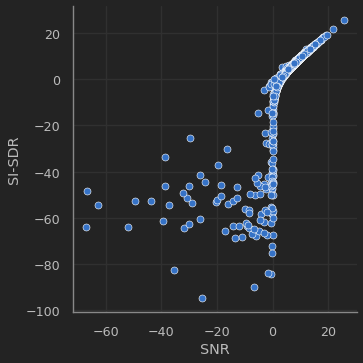

'Demucs'

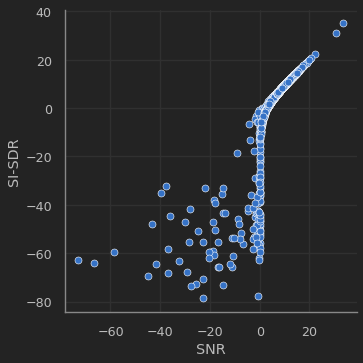

'ConvTasNet'

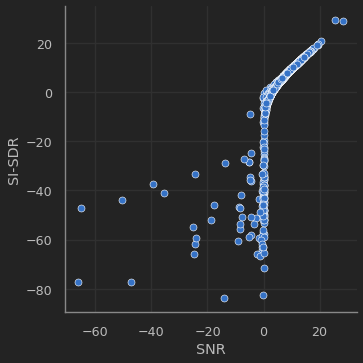

'Wave-U-Net'

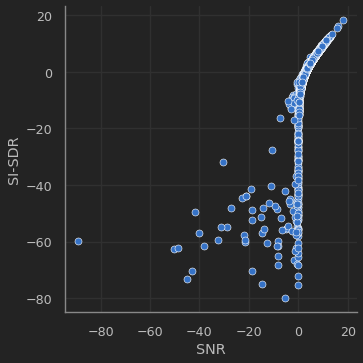

Outliers for source other
{'1622.json', '1616.json', '1635.json', '1617.json', '1648.json', '1646.json', '1629.json', '1647.json', '1619.json', '1649.json', '1641.json', '1650.json', '1636.json', '1642.json', '1618.json', '1644.json', '1623.json', '1628.json', '1615.json', '1638.json', '1651.json', '1625.json', '1639.json', '1614.json', '1630.json', '1626.json', '1640.json', '1633.json', '1643.json', '1634.json', '1645.json', '1627.json', '1624.json', '1621.json', '1631.json', '1620.json', '1637.json', '1632.json'}


'OpenUnmix'

,mean,median,std dev
SNR,5.541480,5.508439,2.815670
SI-SDR,3.683682,4.144024,4.578981
SI-SDRi,9.015390,8.786173,3.913483


'Demucs'

,mean,median,std dev
SNR,6.801028,6.880169,3.178160
SI-SDR,5.482790,5.913836,4.518708
SI-SDRi,10.815468,10.676824,4.048227


'ConvTasNet'

,mean,median,std dev
SNR,6.058500,5.963738,2.778954
SI-SDR,4.412557,4.718716,4.437497
SI-SDRi,9.745235,9.511264,3.812869


'Wave-U-Net'

,mean,median,std dev
SNR,3.732521,3.558328,2.310954
SI-SDR,0.797138,1.203210,4.443818
SI-SDRi,6.129816,5.984924,3.655125


'OpenUnmix'

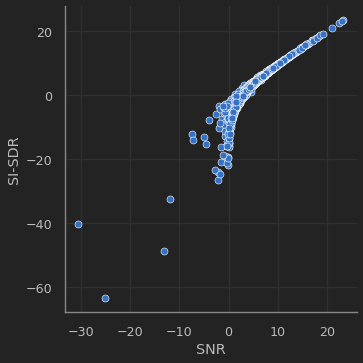

'Demucs'

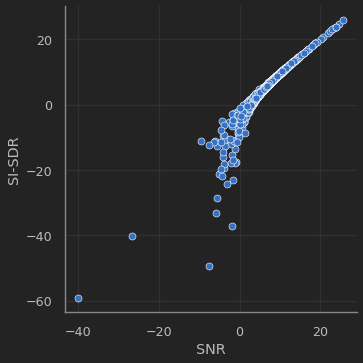

'ConvTasNet'

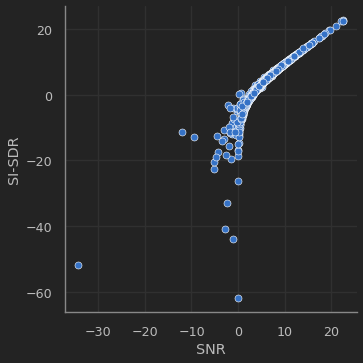

'Wave-U-Net'

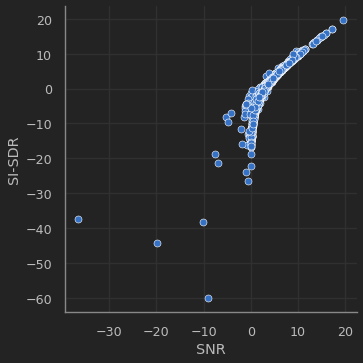

Outliers for source drums
{'1622.json', '1616.json', '1635.json', '1617.json', '1648.json', '746.json', '1646.json', '1629.json', '748.json', '1647.json', '1619.json', '743.json', '755.json', '1649.json', '1641.json', '1650.json', '747.json', '1636.json', '744.json', '1642.json', '1618.json', '1644.json', '742.json', '1623.json', '1628.json', '1615.json', '1638.json', '754.json', '1651.json', '749.json', '1625.json', '1639.json', '1614.json', '1630.json', '1626.json', '1640.json', '745.json', '1633.json', '751.json', '753.json', '1643.json', '1634.json', '1645.json', '752.json', '750.json', '1627.json', '1624.json', '1621.json', '1631.json', '1620.json', '1637.json', '1632.json'}


'OpenUnmix'

,mean,median,std dev
SNR,6.589424,6.541997,3.269584
SI-SDR,5.069688,5.512859,5.162307
SI-SDRi,12.422011,12.125432,3.599868


'Demucs'

,mean,median,std dev
SNR,9.078992,8.988478,3.241924
SI-SDR,8.167880,8.458243,5.192358
SI-SDRi,15.542737,15.255698,3.946234


'ConvTasNet'

,mean,median,std dev
SNR,7.815598,7.729546,3.151032
SI-SDR,6.448067,6.964081,6.058134
SI-SDRi,13.822924,13.604315,4.143934


'Wave-U-Net'

,mean,median,std dev
SNR,7.777167,8.212097,4.191242
SI-SDR,6.256664,7.535086,6.489398
SI-SDRi,13.631522,14.377253,5.453167


'OpenUnmix'

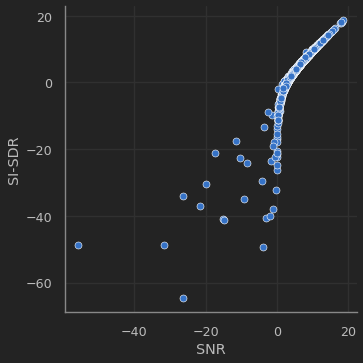

'Demucs'

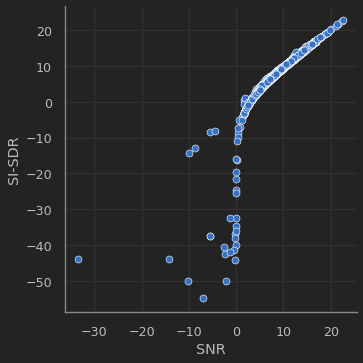

'ConvTasNet'

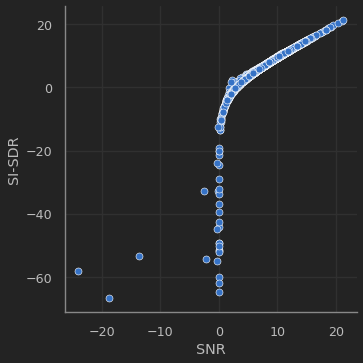

'Wave-U-Net'

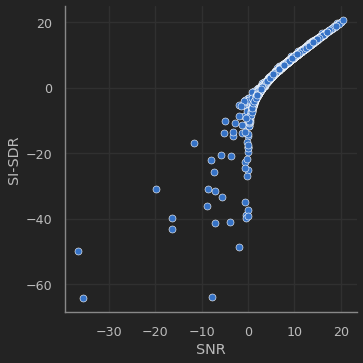

In [14]:
def find_outlier_files(outliers):
    outlier_indices = set()
    num = 0
    for idx, segment_list in enumerate(musdb.segments):
        if idx in outliers:
            outlier_indices |= set(range(num, num + len(segment_list)))
        num += len(segment_list)
    outlier_files = {f"{o}.json" for o in outlier_indices}
    return outlier_files

# Generate Summary Statistics for outlier-less tracks
for source in ["bass", "vocals", "other", "drums"]:
    print(f"Outliers for source {source}")
    outliers = problem_songs[source]
    outlier_files = find_outlier_files(outliers)
    print(outlier_files)
    raw_outlier_1 = {}
    for model_name, df in raw_data.items():
        raw_outlier_1[model_name] = df[~df["file"].isin(outlier_files)]
    # Overall Summary Statistics
    raw_source_o1, summary_source_o1, raw_aggregate_o1, summary_aggreggate_o1 = generate_aggreggates(raw_outlier_1)
#     for model, df in summary_aggreggate_o1.items():
#         display(model)
#         display(df.loc[["SNR", "SI-SDR", "SI-SDRi"]])

    # Summary Statistics for source, (which is used as the source for papers with code)
    for model, dict_df in summary_source_o1.items():
        display(model)
        df = dict_df[source]
        values = df.loc[["SNR", "SI-SDR", "SI-SDRi"]]
        display(values)

    for model_name, dict_df in raw_source_o1.items():
        display(model_name)
        sns.relplot(data=dict_df[source]
                    # [dict_df["vocals"]["SI-SDR"] > 0]
                    , x="SNR", y="SI-SDR")
        plt.grid()
        plt.show()


## Conclusions
+ Outliers in specific sources are not affecting the ranking of models.
+ 
#### Drawbacks to this approach:
+ For a stem to be labeled a an outlier, it must be a fail case on all models. This will not affect any model substantial

# Part 4: Statistical Tests
We look at SI-SDR with a one-sided Wilcoxon signed rank test. 

In [11]:
from scipy.stats import wilcoxon
for model_name_1, source_data_1 in raw_source_data.items():
    for model_name_2, source_data_2 in raw_source_data.items():
        # We check if 1 is greater than 2
        if model_name_1 == model_name_2:
            continue
        sources = source_data_1.keys()
        for source in sources:
            data_1 = pd.Series(
                data=source_data_1[source]["SI-SDR"].to_numpy(),
                index=source_data_1[source]["file"]
            )
            data_2 = pd.Series(
                data=source_data_2[source]["SI-SDR"].to_numpy(),
                index=source_data_2[source]["file"]
            )
            diff = (data_1 - data_2).to_numpy(dtype=float)
            w, p = wilcoxon(diff, alternative="greater")
            print(f"""
            Alternative Hypothesis: {model_name_1} > {model_name_2}
            Source: {source}
            Statistic: {w}
            P-Value: {p}
            """
            )



            Alternative Hypothesis: OpenUnmix > Demucs
            Source: bass
            Statistic: 166487.0
            P-Value: 1.0
            

            Alternative Hypothesis: OpenUnmix > Demucs
            Source: drums
            Statistic: 81244.0
            P-Value: 1.0
            

            Alternative Hypothesis: OpenUnmix > Demucs
            Source: other
            Statistic: 486451.0
            P-Value: 1.0
            

            Alternative Hypothesis: OpenUnmix > Demucs
            Source: vocals
            Statistic: 1424967.0
            P-Value: 1.0
            

            Alternative Hypothesis: OpenUnmix > ConvTasNet
            Source: bass
            Statistic: 427868.0
            P-Value: 1.0
            

            Alternative Hypothesis: OpenUnmix > ConvTasNet
            Source: drums
            Statistic: 412249.0
            P-Value: 1.0
            

            Alternative Hypothesis: OpenUnmix > ConvTasNet
            Source: o

# Part 5:
Ethan asked for this graph. 
Similar to Fig. 3 in https://arxiv.org/pdf/1911.02182.pdf

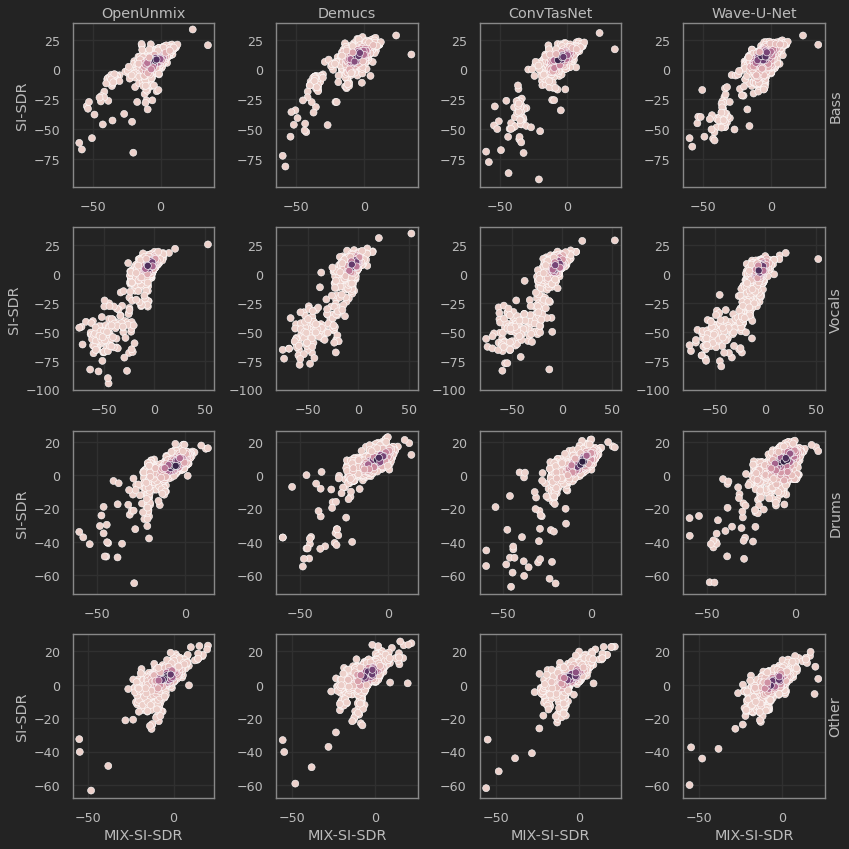

In [9]:
import numpy as np
from scipy.stats import gaussian_kde
source_types = ['bass', 'vocals', 'drums', 'other']
fig, axes = plt.subplots(len(source_types), len(raw_source_data), figsize=(12, 12))
limits = np.zeros((len(source_types), 2))
for m_idx, (model, data) in enumerate(raw_source_data.items()):
    ax = axes[0][m_idx]
    ax.set_title(model)
    for s_idx, source in enumerate(source_types):
        source_data = data[source]
        ax = axes[s_idx][m_idx]
        x = source_data["MIX-SI-SDR"]
        y = source_data["SI-SDR"]
        xy = np.vstack([x.to_numpy(), y.to_numpy()])
        z = gaussian_kde(xy)(xy)
        sns.scatterplot(x=x, y=y, hue=z*10, ax=ax, legend=False)
        if m_idx == len(raw_source_data) - 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(source.capitalize())
        elif m_idx > 0:
            ax.set_ylabel("")
        if s_idx < len(source_types) - 1:
            ax.set_xlabel("")
        ax.grid()
        y_low, y_high = ax.get_ylim()
        limits[s_idx, 0] = min(limits[s_idx, 0], y_low)
        limits[s_idx, 1] = max(limits[s_idx, 1], y_high)
        
for idx, ax_list in enumerate(axes):
    for ax in ax_list:
        ax.set_ylim(*limits[idx])
fig.tight_layout()
fig.show()